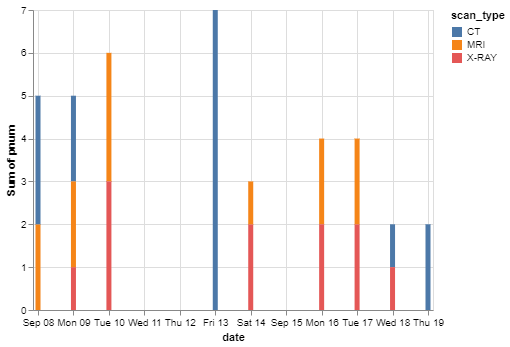

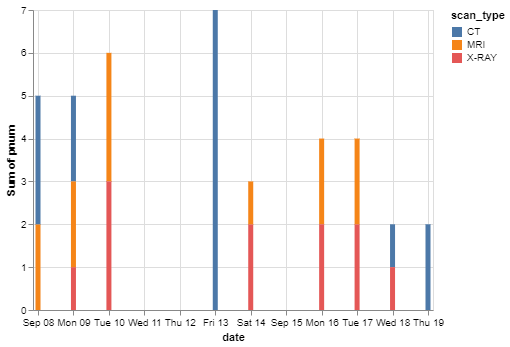

In [11]:
# Scan types against dates

import json
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

with open('logs.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data).transpose()
df1 = df.reset_index().drop(columns=['index','key','what'])
df1['when'] = pd.to_datetime(df1.when)
df2 = df1.set_index(['ref_type','log_type','when']).sort_index()

li = []
df3 = df2.loc[('APPOINTMENT','COMPLETED'),:].reset_index('when').sort_index()
for x in df3['ref_key']:
    li.append(x)
    
with open('appointments.json','r') as f:
    app_data = json.load(f)
    
app_df = pd.DataFrame(app_data).transpose()
app_df1 = app_df.loc[li]

app_df2 = app_df1.reset_index()
app_df3 = app_df2.loc[:,['index','procedures']]
app_dict = app_df3.to_dict(orient = 'index')

alist=[]
for a in app_dict:
    for p in app_dict[a]['procedures']:
        alist.append({'appointment':app_dict[a]['index'], 'procedure':p})
        
app_df4 = pd.DataFrame(alist)

with open('procedures.json','r') as f:
    pro_data = json.load(f)
    
pro_df = pd.DataFrame(pro_data).transpose()
pro_df1 = pro_df.loc[app_df4['procedure']]
pro_df2 = pro_df1.reset_index().rename(columns={'index':'procedure'})

prolog_df = pro_df2.set_index('appointment').join(df3.set_index('ref_key'))\
            .reset_index().rename(columns ={'index':'appointment'})\
            .set_index('when')

prolog_df1 = prolog_df.loc[:,('appointment','procedure','scan_type')]

prolog_df1.reset_index().when.dt.date
adf1 = prolog_df1.reset_index()
adf1['day'] = adf1.when.dt.date

adf2 = adf1.loc[:,['procedure','scan_type','day']]
adf2['pnum'] = adf2.procedure.map(lambda p: 1)
adf2['date'] = pd.to_datetime(adf2.day)

adf3 = adf2.drop(columns=['day','procedure'])

alt.Chart(adf3).mark_bar().encode(
    x='date:T',
    y='sum(pnum)',
    color='scan_type'
)

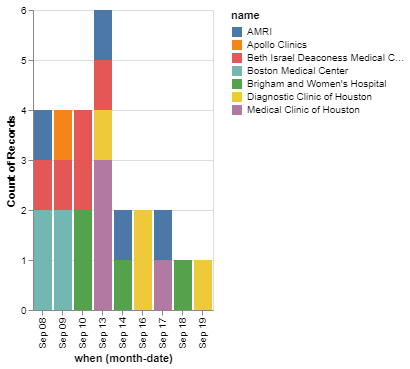

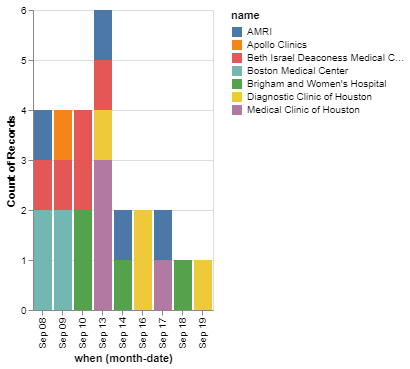

In [12]:
# clinic count of procedures against dates

import json
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

with open('logs.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data).transpose()
df1 = df.reset_index().drop(columns=['index','key','what'])
df1['when'] = pd.to_datetime(df1.when)
df2 = df1.set_index(['ref_type','log_type','when']).sort_index()

li = []
df3 = df2.loc[('APPOINTMENT',),:].reset_index('when').sort_index()
for x in df3['ref_key']:
    li.append(x)
    
with open('appointments.json','r') as f:
    app_data1 = json.load(f)
    
appointments_df = pd.DataFrame(app_data1).transpose()

with open('clinics.json','r') as f:
    clinics_data1 = json.load(f)
    
clinics_df = pd.DataFrame(clinics_data1).transpose()

completed_df = df3.loc[('COMPLETED',),:].copy()
stage1 = completed_df.reset_index().set_index('ref_key')\
                     .join(appointments_df)\
                     .loc[:,['when','clinic']]

data_df = stage1.reset_index().set_index('clinic')\
      .join(clinics_df)\
      .loc[:,['when','name','ref_key']]\
      .reset_index()

alt.Chart(data_df).mark_bar().encode(
    x='monthdate(when):O',
    y='count(ref_key)',
    color='name'
)

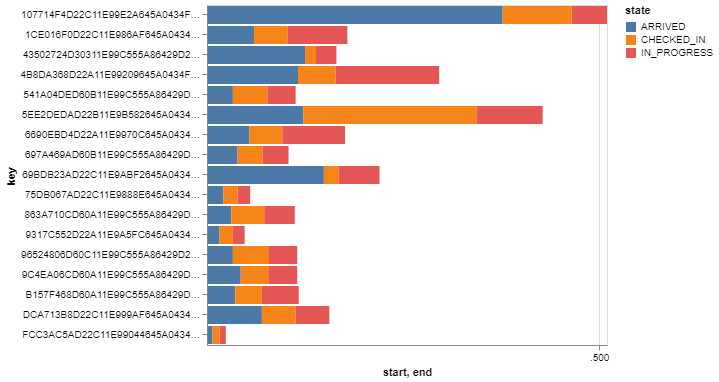

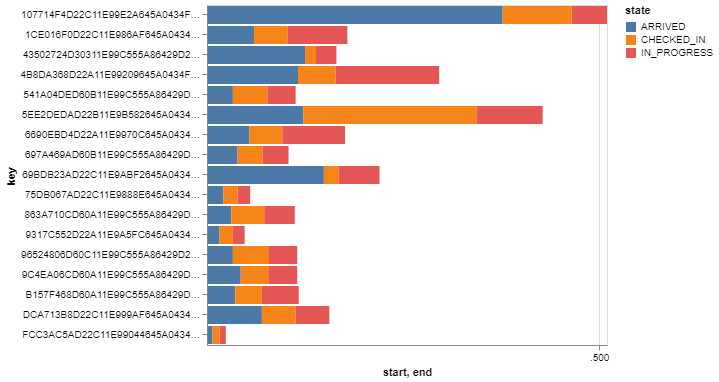

In [9]:
# time taken for each steps against time

import json
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

with open('logs.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data).transpose()
df.reset_index().set_index('key')

a = df.reset_index().set_index(['ref_type','ref_key','log_type']).sort_index()\
      .loc[('APPOINTMENT',)]

b = a.when.to_frame()\
    .loc[pd.IndexSlice[:,['ARRIVED','CHECKED_IN','IN_PROGRESS','COMPLETED']],:]\
    .unstack('log_type').when
b.ARRIVED = pd.to_datetime(b.ARRIVED)
b.CHECKED_IN = pd.to_datetime(b.CHECKED_IN)
b.IN_PROGRESS = pd.to_datetime(b.IN_PROGRESS)
b.COMPLETED = pd.to_datetime(b.COMPLETED)

c = b.loc[:,['CHECKED_IN','IN_PROGRESS','COMPLETED']].copy()
for col in c.columns:
    u = (c[col] - b.ARRIVED)
    c[col] = 24*60*60*u.dt.days + u.dt.seconds
    
data = []
for k,row in c.iterrows():
    data.append({
        'key': k,
        'state': 'ARRIVED',
        'start': 0,
        'end': row.CHECKED_IN
    })
    data.append({
        'key': k,
        'state': 'CHECKED_IN',
        'start': row.CHECKED_IN,
        'end': row.IN_PROGRESS
    })
    data.append({
        'key': k,
        'state': 'IN_PROGRESS',
        'start': row.IN_PROGRESS,
        'end': row.COMPLETED
    })
    
appt_source = pd.DataFrame(data).dropna()

y_axis = alt.Axis(
    title='Question',
    offset=5,
    ticks=False,
    minExtent=60,
    domain=False
)

alt.Chart(appt_source).mark_bar().encode(
    x='start:T',
    x2='end:T',
    y='key:N',
    color=alt.Color(
        'state:N'
    )
)

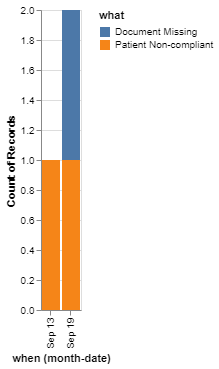

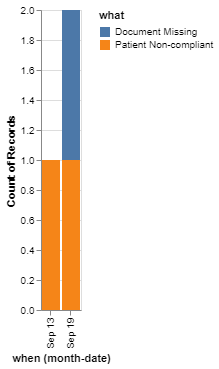

In [13]:
# Reason for appointment rejection

import json
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

with open('logs.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data).transpose()
df1 = df.reset_index().drop(columns=['index','key'])
df1['when'] = pd.to_datetime(df1.when)
df2 = df1.set_index(['ref_type','log_type','when']).sort_index()

df3 = df2.loc[('APPOINTMENT','CANCELLED'),:].reset_index('when').sort_index()

alt.Chart(df3).mark_bar().encode(
    x='monthdate(when):O',
    y='count(who):O',
    color='what'
)

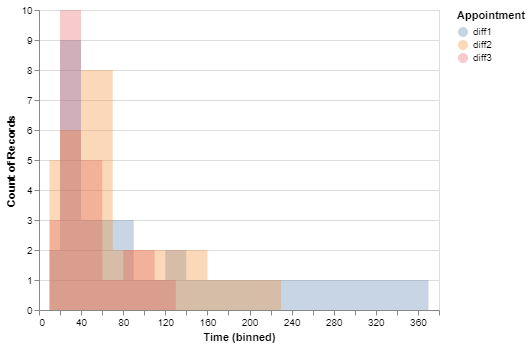

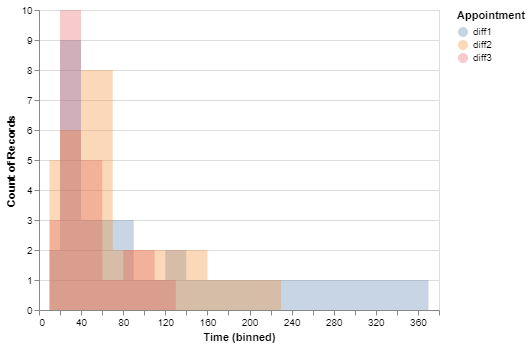

In [14]:
# counts of records against appointment

import json
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

with open('logs.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data).transpose()
df.reset_index().set_index('key')

a = df.reset_index().set_index(['ref_type','ref_key','log_type']).sort_index()\
      .loc[('APPOINTMENT',)]

b = a.when.to_frame()\
    .loc[pd.IndexSlice[:,['ARRIVED','CHECKED_IN','IN_PROGRESS','COMPLETED']],:]\
    .unstack('log_type').when
b.ARRIVED = pd.to_datetime(b.ARRIVED)
b.CHECKED_IN = pd.to_datetime(b.CHECKED_IN)
b.IN_PROGRESS = pd.to_datetime(b.IN_PROGRESS)
b.COMPLETED = pd.to_datetime(b.COMPLETED)

t1 = (b.CHECKED_IN - b.ARRIVED)
d1 = 24*60*60*t1.dt.days + t1.dt.seconds

t2 = (b.IN_PROGRESS - b.CHECKED_IN)
d2 = 24*60*60*t2.dt.days + t2.dt.seconds

t3 = (b.COMPLETED - b.IN_PROGRESS)
d3 = 24*60*60*t3.dt.days + t3.dt.seconds

data = pd.DataFrame({'diff1':d1, 'diff2':d2, 'diff3':d3}).dropna()

alt.Chart(data).transform_fold(
    ['diff1', 'diff2', 'diff3'],
    as_=['Appointment', 'Time']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('Time:Q', bin=alt.Bin(maxbins=20)),
    alt.Y('count()', stack=None),
    alt.Color('Appointment:N')
)

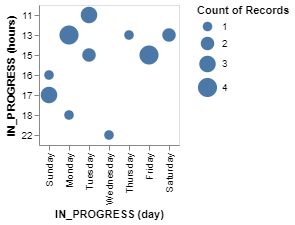

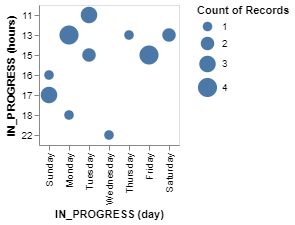

In [15]:
# no. of procedures against hourly time

import json
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

with open('logs.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data).transpose()
df.reset_index().set_index('key')

a = df.reset_index().set_index(['ref_type','ref_key','log_type']).sort_index()\
      .loc[('APPOINTMENT',)]

b = a.when.to_frame()\
    .loc[pd.IndexSlice[:,['IN_PROGRESS']],:]\
    .unstack('log_type').when

b.IN_PROGRESS = pd.to_datetime(b.IN_PROGRESS)
t1 = b.IN_PROGRESS
t2 = t1.reset_index().drop(columns=['ref_key'])

alt.Chart(t2).mark_circle().encode(
    y='hours(IN_PROGRESS):O',
    x='day(IN_PROGRESS):O',
    size='count(IN_PROGRESS):Q'
)